# Generating information footprints for Reg-Seq with MAVE-NN
## by Kian Faizi

In [53]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

import mavenn
from mavenn.src.layers.gpmap import GPMapLayer

In [55]:
dataset = Path('/home/kian/projects/regseq_analysis/LB_data.csv')
data_df = pd.read_csv(dataset)
data_df = data_df.dropna()

In [56]:
# calculate sequence lengths (needed for defining model)
data_df['seq_len'] = data_df['seq'].map(len)

# grab the first value
L = data_df.loc[0,'seq_len']

print('sequence length is', L, 'bp')

# (but check that all are equal, as required by MAVE-NN)
for i in data_df.loc[:,'seq_len']:
    if i != L:
        raise Exception('input sequence lengths are not constant!')

sequence length is 160 bp


In [57]:
# add column for normalized barcode counts
data_df['counts_barcode'] = data_df['counts_RNA']/data_df['counts_DNA']
data_df

,Unnamed: 0,counts_RNA,barcode,counts_DNA,seq,gene,nmut,seq_len,counts_barcode
0,0,303.0,TCCACAACTATGCTGTCAGA,3385.0,TCTGGATGTCGTTCTGAAGGTGCTGGATTAATATATCAAGTAATGC...,thiM,19,160,0.089513
1,1,37.0,TCTTCGGTGTGCGCTTGAGG,261.0,TCTCGCATAAGCACCTTATGCCCGATGATATTTCTTTCATCGGGCT...,poxB,13,160,0.141762
2,2,0.0,GGACGGTTCAGGTACATGTC,8.0,CGGCTGAACTTTATCAACAAAGGCCACATTGCGGAAGATGGCATTC...,ybiO,18,160,0.000000
3,3,14.0,GGTGACCCTGGCTACGCGGG,219.0,CGGCTGATCTTTAGCGACAAAGGCCGGATGGCGGAAGATGGCCATC...,ybiO,15,160,0.063927
4,4,0.0,GCCGGCGCGTAAGTTGGAGG,51.0,CGACACATCTATATCGACAAAGGCCGGATTGCGGAAGATGGCAATC...,ybiO,18,160,0.000000
...,...,...,...,...,...,...,...,...,...
285054,285054,73.0,AGGAGAACGGATTTGACGCC,29.0,AAAAACGGATTACATACACAATACGCCCAACAGCGAAAGATACCTG...,yodB,10,160,2.517241
285055,285055,3.0,ACCCGCACTCCATCCTTGAT,4.0,AAAAACACAAAAAAAATGAAGGTGTAGCGGCAGATCAGAGCAAACT...,WaaA-coaD,18,160,0.750000
285056,285056,7.0,GATTATACGTGAAGGCCAAC,7.0,AAAAACACAAAAAAAACGAAGCTGTAGCGCCAGATCCGACGAAACT...,WaaA-coaD,16,160,1.000000
285058,285058,13.0,TGACGTGTCTAGTTCATTTC,22.0,AAAAAAACAAAAAATATGAAGATGTAGCGGCAGATGAGACCAAACT...,WaaA-coaD,11,160,0.590909


During training, the 'training' and 'validation' datasets are used. The rough process is as follows (h/t SE):
```for each epoch
    for each training data instance
        propagate error through the network
        adjust the weights
        calculate the accuracy over training data
    for each validation data instance
        calculate the accuracy over the validation data
    if the threshold validation accuracy is met
        exit training
    else
        continue training
```

Finally, the test set is used to assess performance.

A typical split might look like 70% training, 20% validation, and 10% test.

In [58]:
# get a 70% training set
train, testval = train_test_split(data_df, test_size=0.3)
train['set'] = 'training'

# split the remainder into 21% validation, 9% test
validation, test = train_test_split(testval, test_size=0.3)
validation['set'] = 'validation'
test['set'] = 'test'

# reform data_df with new labels
data_df = pd.concat([train, validation, test])
data_df

,Unnamed: 0,counts_RNA,barcode,counts_DNA,seq,gene,nmut,seq_len,counts_barcode,set
255527,255527,7.0,ACGCTCTGCACCTTATTTAG,24.0,TGTTCAACACAGTGTATTCATGGAACAGTCTACGTCGTCGACGAAT...,msyB,20,160,0.291667,training
18840,18840,0.0,CTTACGTGATCAAGTAACGG,66.0,TCGATCTCCCCGTAAAATATGAGCGATGGCGAAAGAAATTAAATTA...,ykgE,16,160,0.000000,training
116481,116481,0.0,TGGCATCATCTAAATACGGT,5.0,TCTGGATGTTGTTCTGAAGGTGCTGTATTCATATATCACATAAATT...,thiM,13,160,0.000000,training
133742,133742,4.0,TCTGAAGCCGTATTAGTCCG,27.0,CATTTCCGATTGATGTGGATTGTGTGACCAGGAGAAGGATGAAAAG...,zapB,18,160,0.148148,training
203385,203385,0.0,GAGTAGGCTTCCCTGGGGAT,17.0,TGCATATATTGCACGCCCCGGAAGAAGTTAGGTGTCGTTGAAGGGG...,sdaB,17,160,0.000000,training
...,...,...,...,...,...,...,...,...,...,...
207066,207066,2.0,AGCTGCGTGGTTTGAGATAA,7.0,GTCCACATTGGTTATTTGCACGGCGTCACACTTTGCTATGCCATAG...,araAB,15,160,0.285714,test
129551,129551,32.0,TTCATATATCTAGCAATGAT,46.0,TCTGGATGTCGTTTTGAAGGTGCCGGATCCATAAATCAAGTAATTT...,thiM,15,160,0.695652,test
69198,69198,0.0,AAGCGCAAACCTGGTCCCGC,1.0,TCGCGCCACCACGGTAGAGCTGGACTTCAGCCAGGTTGAAAAAGGC...,rplKAJL-rpoBC,19,160,0.000000,test
68121,68121,4.0,GAGACGAGTGTGCATGCATG,76.0,AGACACGAACAGGCCAAAGGTTTCAGCGTGTATATGCTGCGCGCAA...,ybjT,15,160,0.052632,test


In [59]:
# now, split again but using mavenn's terminology and functions
trainval_df, test_df = mavenn.split_dataset(data_df)

Training set   :  176,397 observations (  70.00%)
Validation set :   52,919 observations (  21.00%)
Test set       :   22,680 observations (   9.00%)
-------------------------------------------------
Total dataset  :  251,996 observations ( 100.00%)



In [62]:
# specify the model to be trained (discrete -> MPA)

# define model
model = mavenn.Model(L=L,
                     alphabet='dna',
                     gpmap_type='additive',
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# set training data
model.set_data(x=trainval_df['seq'],
               y=trainval_df['counts_barcode'],
               validation_flags=trainval_df['validation'])

# train model
model.fit(learning_rate=1e-3,
          epochs=500,
          batch_size=64,
          early_stopping=True,
          early_stopping_patience=25,
          verbose=True)

N = 229,316 observations set as training data.
Using 23.1% for validation.
Data shuffled.
Time to set data: 3.32 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has 176397 rows and 640 columns
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      640

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  4.232e+02  1.362e+04   1.0e+00  7.6e-02
     1  4.37965e-04  4.230e+02  1.048e+04   1.0e+00  3.1e-02  8.0e+02  1.0e+00
     2  1.16910e-03  4.228e+02  4.832e+03   1.0e+00  4.2e-03  2.7e+03  1.3e+00
     3  1.52057e-03  4.227e+02  3.167e+03   1.0e+00  2.6e-03  2.9e+03  3.2e+00
     4  1.73750e-03  4.226e+02  2.562e+03   1.0e+00  2.0e-03  3.0e+03  4.7e+00
     5  1.95855e-03  4.226e+02  2.287e+03   1.0e+00  1.8e-03  3.1e+03  6.8e+00
     6  1.96628e-03  4.225e+02  2.073e+03   1.0e+00  1.6e-03  3.2e+03  8.6e+00
     7  1.85090e-03  4.224e+02  1.842e+0

In [63]:
# Compute variational information on test data
I_var, dI_var =  model.I_variational(x=test_df['seq'], y=test_df['counts_barcode'])
print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['seq'], y=test_df['counts_barcode'])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_var: -0.072 +- 0.022 bits
test_I_pred: 0.009 +- 0.006 bits


In [64]:
# Save model to file
model_name = 'LBtest_additive_ge'
model.save('LBtest')

# Delete model if it is present in memory
try:
    del model
except:
    pass

# Load model from file
model = mavenn.load('LBtest')

# Show metrics recorded in model.history()
model.history.keys()

Model saved to these files:
	LBtest.pickle
	LBtest.h5
Model loaded from these files:
	LBtest.pickle
	LBtest.h5


dict_keys(['loss', 'I_var', 'val_loss', 'val_I_var'])

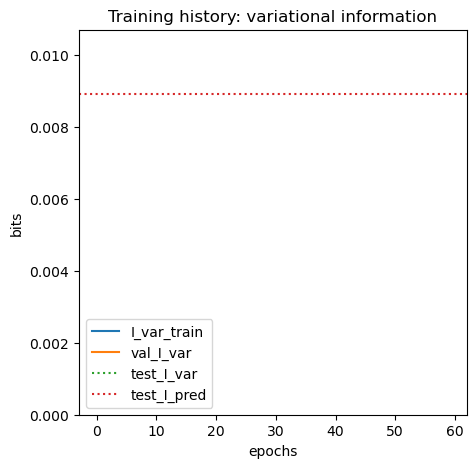

In [65]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'],
        label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'],
        label=r'val_I_var')

# Show I_var_test, the variational information of the final model on test data
ax.axhline(I_var, color='C2', linestyle=':',
           label=r'test_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':',
           label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.set_ylim([0, 1.2*I_pred])
ax.legend()

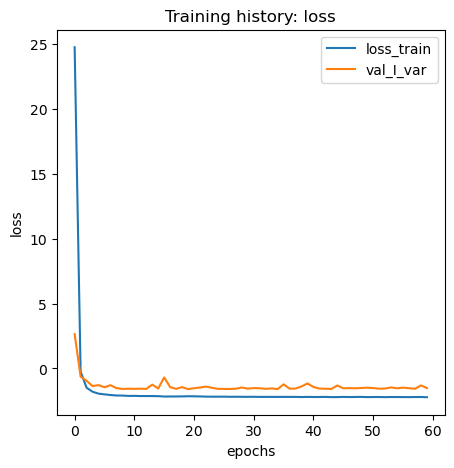

In [66]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Plot loss_train, the loss computed on training data as a function of epoch
ax.plot(model.history['loss'],
        label=r'loss_train')

# Plot loss_val, the loss computed on validation data as a function of epoch
ax.plot(model.history['val_loss'],
        label=r'val_I_var')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Training history: loss')
ax.legend()

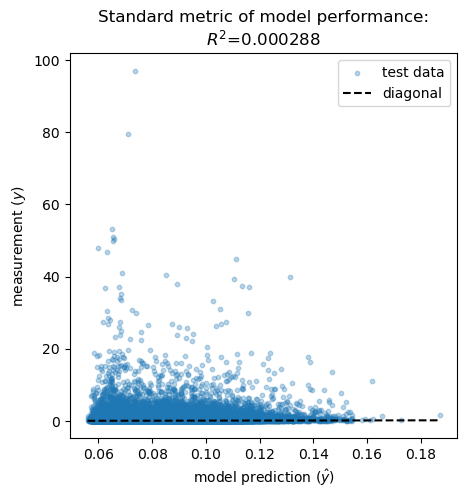

In [70]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['counts_barcode']

# Compute yhat on test data
yhat_test = model.x_to_yhat(test_df['seq'])

# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(yhat_test.ravel(), test_df['counts_barcode'])[0, 1]**2

# Plot y_test vs. yhat_test
ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.3,
           label='test data')

# Style plot
xlim = [min(yhat_test), max(yhat_test)]
ax.plot(xlim, xlim, '--', color='k', label='diagonal', zorder=100)
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Standard metric of model performance:\n$R^2$={Rsq:.3}');
ax.legend()

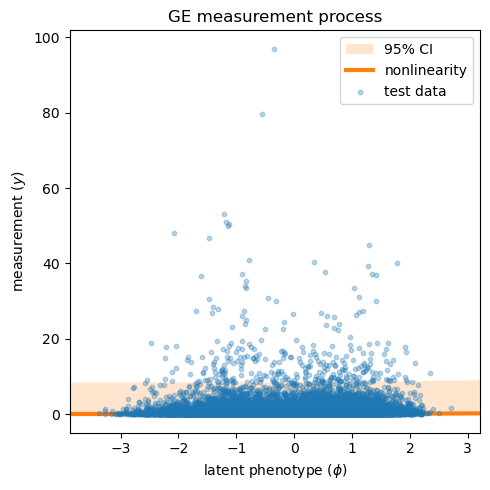

In [71]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1,1,figsize=[5,5])

# Get test data y values
y_test = test_df['counts_barcode']

# Compute φ on test data
phi_test = model.x_to_phi(test_df['seq'])

## Set phi lims and create a grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 95% CI for each yhat
q = [0.025, 0.975]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)


# Plote 95% confidence interval
ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
               alpha=0.2, color='C1', lw=0, label='95% CI')

# Plot GE nonlinearity
ax.plot(phi_grid, yhat_grid,
        linewidth=3, color='C1', label='nonlinearity')

# Plot scatter of φ and y values,
ax.scatter(phi_test, y_test,
           color='C0', s=10, alpha=.3, label='test data',
           zorder=+100, rasterized=True)

# Style plot
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GE measurement process')
ax.legend()
fig.tight_layout()

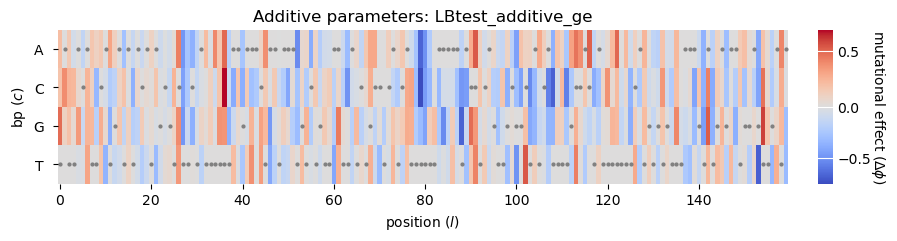

In [79]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.get_theta(gauge='consensus')
theta_dict.keys()

# Create figure
fig, ax = plt.subplots(1,1, figsize=(10,2))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_dict['theta_lc'],
                                alphabet=theta_dict['alphabet'],
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':4},
                                cmap='coolwarm',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('bp ($c$)')
heatmap_ax.set_title(f'Additive parameters: {model_name}')

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')



# maximum = np.max(np.abs(tf_weights))
# fig,ax = plt.subplots(figsize=((10,2)))
# plt.imshow(-np.transpose(tf_weights), origin='upper', cmap='coolwarm', vmax=maximum, vmin=-maximum)
# plt.xlabel('Position')
# ax.set_yticks([0, 1, 2, 3])
# ax.set_yticklabels(['A','C','G','T'])
# ax.set_xticks(np.arange(0, len(tf_weights), step=5))
# ax.set_xticklabels(np.arange(-27, 1, step=5))
# ax.grid(False)
# plt.colorbar()